# Imports and installs

In [20]:
try:
    !test -f mai_nlp_helper_functions.py || wget https://raw.githubusercontent.com/JosPolfliet/vlerick-mai-nlp-2025/main/mai_nlp_helper_functions.py
    from mai_nlp_helper_functions import *
except ImportError as e:
    raise ImportError("You don't have the mai_nlp_helper_functions.py file in the same directory as your notebook. Either add it, or copy paste the contents in this cell") from e


In [2]:
import pandas as pd
import numpy as np
import spacy
import string


from tqdm import tqdm
from sklearn.model_selection import train_test_split

tqdm.pandas()

## Get data

In [3]:
df = pd.read_csv("https://media.githubusercontent.com/media/JosPolfliet/vlerick-mai-nlp-2023/main/DATA/esg_reports.csv")
df["subject"] = df["subject"].fillna("Other")
df

,text,subject
0,"Since its inception in 2010, we have distribut...",Social
1,"I will focus first on traffic, which is a key ...",Other
2,"Also, many farms are aged with degraded soil t...",Environmental
3,"Alaska 2009 STEWARDSHIP REPORT54 cOnSERvATIOn,...",Social
4,The company’s U.S. GOM operations can be impac...,Other
...,...,...
2180,American shad are a species of concern for res...,Environmental
2181,Weyerhaeuser's policies address best practices...,Other
2182,compares recently observed trends in weather p...,Environmental
2183,"If our partners, including our licensors, suff...",Other


## Clean data

In [5]:
def spacy_tokenizer(sentence):
    """
    Tokenises a sentence using spaCy.
    Parameters:
    - sentence: str, the sentence to tokenise
    Returns:
    - mytokens: list, the list of tokens
    """
    # Creating our token object, which is used to create documents with linguistic annotations.
    global nlp
    global stop_words
    if 'nlp' not in globals():
        try:
            nlp = spacy.load("en_core_web_lg")
            stop_words = spacy.lang.en.stop_words.STOP_WORDS
        except:
            spacy.cli.download("en_core_web_lg")
            nlp = spacy.load("en_core_web_lg")
            stop_words = spacy.lang.en.stop_words.STOP_WORDS

    tokens = nlp(sentence["text"].lower())
    # Lemmatise + lower case
    tokens = [
        word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_
        for word in tokens
    ]

    # Remove stop words
    tokens = [
        word for word in tokens if word not in stop_words and word not in string.punctuation
    ]

    return tokens


In [6]:
sentence = df.iloc[302]
print(sentence.text)

It also cultivates open collaborative innovation with the startup ecosystem.


In [7]:
for token in spacy_tokenizer({"text": "The geographic analysis in the Business Review, including the average balance sheet and interest rates, changes in net interest income and average interest rates, yields, spreads and margins in this report have generally been compiled on the basis of location of office - UK and overseas – unless indicated otherwise."}):
    print(token)    

geographic
analysis
business
review
include
average
balance
sheet
interest
rate
change
net
interest
income
average
interest
rate
yield
spread
margin
report
generally
compile
basis
location
office
uk
overseas
–
indicate


In [11]:

def embed_words(sentence):
    tokens = spacy_tokenizer(sentence)
    return nlp.vocab.vectors.get_batch(tokens)
sentence = df.iloc[301]

word_embeddings = embed_words(sentence)
print(word_embeddings)
print(word_embeddings.shape)

[[-0.13018   -0.46249    0.32546   ...  0.087097  -0.29494   -0.14286  ]
 [-0.65106    0.47266    0.10066   ...  0.034387  -0.21083    0.044614 ]
 [-0.26883    0.65052   -0.088267  ... -0.064781   0.069616   0.11012  ]
 ...
 [-0.095506  -0.15364    0.66651   ...  0.12063   -0.029411   0.57962  ]
 [-0.2759     0.40882   -0.18878   ... -0.045396   0.43166   -0.22404  ]
 [ 0.0062794 -0.075699  -0.34946   ...  0.056759   0.28762   -0.24403  ]]
(30, 300)


## Simple model: just average the words

In [12]:
def embed_sentence_simple(sentence):
    """
    This is the part where you can go crazy and complex to add features, change aggregation way, use PCA, ...
    """
    word_embeddings = embed_words(sentence)
    # sentence_embedding = np.concatenate([word_embeddings.min(axis=0), 
    #                                      word_embeddings.max(axis=0), 
    #                                      [embed_words(sentence).shape[0], 
    #                                      len([token for token in nlp(sentence["text"]) if token.is_oov])]])
    # sentence_embedding = np.concatenate([word_embeddings.min(axis=0), word_embeddings.max(axis=0)])
    sentence_embedding = word_embeddings.mean(axis=0)
    return sentence_embedding

sentence_embedding = embed_sentence_simple(sentence)
print(sentence_embedding)
print(sentence_embedding.shape)

[-3.93610358e-01  2.48185813e-01 -8.35004672e-02  6.37098029e-02
  7.17756851e-03 -4.79953215e-02 -7.15299845e-02 -2.78897975e-02
  8.44563544e-02  2.04848027e+00 -4.32947814e-01  1.43495455e-01
 -3.72728711e-04  1.04504570e-01  1.10066645e-01  2.67878361e-02
  1.85123961e-02  1.50923514e+00 -1.72049448e-01 -2.99692147e-05
  4.09781933e-02  4.85453866e-02 -8.94694403e-02 -1.13361798e-01
  1.12782456e-01  1.68230638e-01 -3.58242020e-02  2.45185141e-02
 -5.26977777e-02 -1.52155356e-02  6.96815476e-02  3.31090465e-02
  1.48189962e-01 -5.55702969e-02 -7.44243041e-02  7.74773657e-02
 -1.07830808e-01 -2.65567303e-02 -1.10845082e-01 -1.52327716e-01
 -5.06047346e-02  2.32821293e-02  1.55892938e-01 -6.24782825e-03
  6.63443282e-02  5.14793806e-02  1.10797979e-01 -7.81902764e-03
  7.53916278e-02  5.76389283e-02 -5.59136607e-02 -1.04235403e-01
 -5.84921651e-02 -1.36171162e-01  1.23900928e-01 -1.22730598e-01
 -5.25742695e-02 -1.49017975e-01  3.32778320e-02 -1.17854103e-01
  3.11444961e-02 -5.64181

In [13]:
%%time

df["features_simple"] = df.progress_apply(embed_sentence_simple,axis=1)

# For bigger datasets, you can write the results to disk to cache them
# df.to_pickle("DATA/df_with_features.pkl")

  0%|          | 0/2185 [00:00<?, ?it/s]

100%|██████████| 2185/2185 [00:21<00:00, 100.57it/s]

CPU times: user 20.6 s, sys: 1.05 s, total: 21.6 s
Wall time: 21.7 s


In [10]:
# Load cached results
# df = pd.read_pickle("DATA/df_with_features.pkl")

## Classify

In [15]:
df.head()

,text,subject,features_simple
0,"Since its inception in 2010, we have distribut...",Social,"[0.27818626, -0.07368738, 0.20140126, -0.15395..."
1,"I will focus first on traffic, which is a key ...",Other,"[0.0410976, 0.42800403, -0.19908169, -0.085399..."
2,"Also, many farms are aged with degraded soil t...",Environmental,"[-0.39166, 0.4878684, -0.09345688, -0.04102837..."
3,"Alaska 2009 STEWARDSHIP REPORT54 cOnSERvATIOn,...",Social,"[0.08985256, -0.12161908, 0.08430875, -0.13705..."
4,The company’s U.S. GOM operations can be impac...,Other,"[-0.07093784, 0.06784545, 0.14318354, -0.01350..."


In [16]:
X = np.stack(df["features_simple"].values)
y = np.array(df["subject"])


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22141)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")



X_train shape: (1638, 300)
X_test shape: (547, 300)
y_train shape: (1638,)
y_test shape: (547,)


In [18]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=3, random_state=22141, class_weight="balanced", n_estimators=500)
clf.fit(X_train, y_train)



CPU times: user 3.03 s, sys: 85.5 ms, total: 3.12 s
Wall time: 3.91 s


RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=500,
                       random_state=22141)

## Evaluate

               precision    recall  f1-score   support

Environmental       0.87      0.76      0.81       299
        Other       0.67      0.81      0.74       115
       Social       0.63      0.71      0.67       133

     accuracy                           0.76       547
    macro avg       0.73      0.76      0.74       547
 weighted avg       0.77      0.76      0.76       547



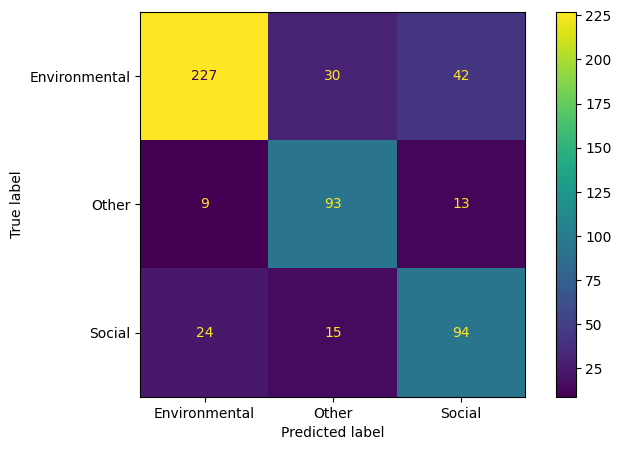

/Users/jospolfliet/src/vlerick-mai-2025/mai_nlp_helper_functions.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([stats])], ignore_index=True)


In [21]:

experiment_name = input("Enter experiment name: ")
predictions = clf.predict(X_test)
stats = evaluate_model(y_test, predictions, clf.classes_)
log_experiment_results(experiment_name, stats["macro avg"])

## What's next?

The example above is to illustrate the theory of embeddings. In reality, you can build pipelines super easily with SpaCy (if you prioritize speed) or HuggingFace transfomers (if you prioritize accuracy)

https://medium.com/@ycouble/training-and-integrating-a-custom-text-classifier-to-a-spacy-pipeline-b19e6a132487